Данный ноутбук содержит признаки, которые основаны на HRV сигнале

In [1]:
import numpy as np
from scikits.audiolab import Sndfile
from scipy import signal
import seaborn as sns
import os
from scikits.audiolab import wavread
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.signal import wiener
import xgboost as xgb
from sklearn.model_selection  import GroupKFold
from biosppy.signals import ecg
from tqdm import tqdm
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from itertools import chain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import gensim
from scipy.signal import butter
from scipy.signal import medfilt
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.computation import RecurrencePlotComputation
from pyrqa.image_generator import ImageGenerator
import nolds
import pyeeg
from scipy.stats import entropy
import numpy as np
from numpy.linalg import eig, inv

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from biosppy.signals.ecg import engzee_segmenter, gamboa_segmenter, hamilton_segmenter, ssf_segmenter

СЧИТЫВАНИЕ ДАННЫХ

In [3]:
true_files = filter(lambda x: x.endswith(".wav"), os.listdir("ibs_true"))
false_files = filter(lambda x: x.endswith(".wav"), os.listdir("ibs_false"))

In [4]:
def read_frame(directory, filename):
    data, sample_frequency, encoding = wavread(directory + "/" + filename)
    return np.array(data)

In [5]:
def get_frames(directory, files):
    frames = []
    for i in files:
        patient = i.split("_")[0]
        a = read_frame(directory, i)
        frames.append([a, patient])
    frames = np.array(frames)
    return np.swapaxes(frames, 0, 1)

In [6]:
true_frames = get_frames("ibs_true", true_files)
false_frames = get_frames("ibs_false", false_files)

In [7]:
def create_data_frame(data, ibs):
    df = pd.DataFrame({"S":data[0], "Patient": data[1], "ibs":ibs})
    return df

In [8]:
a = create_data_frame(true_frames, True)
b = create_data_frame(false_frames, False)

In [9]:
df = a.append(b).copy()

In [10]:
del a
del b

In [11]:
df = shuffle(df, random_state=27)
df = df.reset_index()

In [12]:
df["SignalLen"] = df["S"].apply(lambda x: len(x))
df = df[df["SignalLen"] != 0].copy()

In [13]:
import math

Предобработка данных

In [14]:
N  = 2   # Filter order
Wn_high = 0.3 * 2 / 2000 # Cutoff frequency
B_high, A_high = signal.butter(N, Wn_high, btype='highpass', output='ba', analog=False)
Wn_low = 15 * 2.0 / 2000 # Cutoff frequency
B_low, A_low = signal.butter(N, Wn_low, btype='lowpass', output='ba', analog=False)

In [15]:
def make_preprocessing(x):
    x_p = signal.filtfilt(B_high, A_high, x)
    x_p = signal.filtfilt(B_low, A_low, x_p)
    m = medfilt(x_p, kernel_size=55)
    x_p = x_p - m
    return x_p

In [17]:
from tqdm import tqdm

In [45]:
tqdm.pandas(desc="my bar!")

In [19]:
df["PS"] = df["S"].progress_apply(lambda x: make_preprocessing(x))

my bar!: 100%|██████████| 3031/3031 [39:42<00:00,  1.18it/s]


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

Обнаружение R-пиков

In [22]:
def get_max(x, r):
    w = 10
    d = []
    for i in r:
        if i > 5:
            c = np.argmax(x[i-5: i+5])
            d.append(c+i-5)
    return d

In [23]:
df["RPeaks"] = df["PS"].progress_apply(lambda x: get_max(x, hamilton_segmenter(x)[0]))

my bar!: 100%|██████████| 3031/3031 [15:09<00:00,  2.99it/s]


In [24]:
def get_hrv(r):
    rr = []
    for i in range(len(r)-1):
        rr.append(r[i+1]-r[i])
    return rr

Построение HRV сигнала

In [25]:
df["RR"] = df["RPeaks"].apply(lambda x: get_hrv(x))
df["HRV"] = df["RR"].apply(lambda x: [60.0 / i for i in x])

Признаки основанные на Reccurence plot

In [26]:
def get_r_res(x):
    settings = Settings(x,
                        embedding_dimension=2,
                        time_delay=2,
                        neighbourhood=FixedRadius(0.003),
                        similarity_measure=EuclideanMetric,
                        theiler_corrector=1.0,
                        min_diagonal_line_length=2,
                        min_vertical_line_length=2,
                        min_white_vertical_line_length=2)
    computation = RQAComputation.create(settings, verbose=False)
    result = computation.run()
    return result

def get_rp_f(df):
    df = df.copy()
    df["res_r"] = df["HRV"].progress_apply(lambda x: get_r_res(x))
    df["REC"] = df["res_r"].progress_apply(lambda x: x.recurrence_rate)
    df["DET"] = df["res_r"].progress_apply(lambda x: x.determinism)
    df["Lmean"] = df["res_r"].progress_apply(lambda x: x.average_diagonal_line)
    df["Ed"] = df["res_r"].progress_apply(lambda x: x.entropy_diagonal_lines)
    df["Ev"] = df["res_r"].progress_apply(lambda x: x.entropy_vertical_lines)
    df["Wa"] = df["res_r"].progress_apply(lambda x: x.average_white_vertical_line)
    df.drop("res_r", inplace=True, axis=1)
    return df

In [ ]:
Признаких, основанные на энтропиях и DFA

In [109]:
def get_e_vectors(x, m):
    x_is = []
    for i in range(len(x)- (m-1)):
        x_i = x[i:i+m]
        x_is.append(x_i)
    return np.array(x_is)

def d(x_i, x_j):
    return np.max(np.abs(x_i-x_j))

def c_i_m(x_is, x_i, m, r, N):
    return x_is[d(x_i, x_is) < r].shape[0] * 1.0 / (N-m+1) 

def get_phi(x_is, m, r, N):
    return 1.0 / (N - m + 1) * np.sum([np.log(c_i_m(x_is, i, m, r, N)) for i in x_is])

def get_ap_entropy(x, r):
    m = 10
    N = len(x)
    x_is_m_1 = get_e_vectors(x, m-1)
    x_is_m_2 = get_e_vectors(x, m)
    return get_phi(x_is_m_1, m-1, r, N) - get_phi(x_is_m_2, m, r, N)

def get_sh_en(x):
    n = len(x)
    if n <= 1:
        return 0
    counts = np.bincount(x)
    probs = counts * 1.0 / n
    en = entropy(probs)
    return en

def get_entropies_features(df):
    df = df.copy()
    df["rd"] = df["PS"].apply(lambda x: 0.2 * np.std(x))
    df["ap_e"] = df[["HRV", "rd"]].apply(lambda x: get_ap_entropy(x[0], x[1]), axis=1)
    df["cor_d"] = df["HRV"].progress_apply(lambda x: nolds.corr_dim(x, emb_dim=10))
    df["se"] = df[["HRV", "rd"]].apply(lambda x: pyeeg.samp_entropy(np.array(x[0]), 10, x[1]), axis=1)
    df["dfa"] = df["RR"].progress_apply(lambda x: nolds.dfa(x))
    df["sh_en"] = df["HRV"].progress_apply(lambda x: get_sh_en(x))
    return df

Признаки, основанные на Poincare Plot

In [110]:
def get_poincare_plt(x):
    p_x = []
    p_y = []
    for i in range(len(x)-1):
        p_x.append(x[i])
        p_y.append(x[i+1])
    return [p_x, p_y]

def fit_ellipse(data):
    x = np.array(map(float, data[0]))
    y = np.array(map(float, data[1]))

    D1 = np.mat(np.vstack([x**2, x*y, y**2])).T
    D2 = np.mat(np.vstack([x, y, np.ones(len(x))])).T
    
    S1 = D1.T*D1
    S2 = D1.T*D2
    S3 = D2.T*D2  
    
    C1 = np.mat('0. 0. 2.; 0. -1. 0.; 2. 0. 0.')
    M=C1.I*(S1-S2*S3.I*S2.T)
    eval, evec = np.linalg.eig(M) 
    cond = 4*np.multiply(evec[0, :], evec[2, :]) - np.power(evec[1, :], 2)
    a1 = evec[:, np.nonzero(cond.A > 0)[1]]
    a2 = -S3.I*S2.T*a1
    coef = np.vstack([a1, a2])

    return coef
        
def get_parameters(coef):
    a = coef[0,0]
    b = coef[1,0]/2.
    c = coef[2,0]
    d = coef[3,0]/2.
    f = coef[4,0]/2.
    g = coef[5,0]
    
    x0 = (c*d-b*f)/(b**2.-a*c)
    y0 = (a*f-b*d)/(b**2.-a*c)
    
    numerator = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    denominator1 = (b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    denominator2 = (b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    width = np.sqrt(numerator/denominator1)
    height = np.sqrt(numerator/denominator2)

    phi = .5*np.arctan((2.*b)/(a-c))

    return [x0, y0], width, height, phi


def get_poincare_plots_f(df):
    df = df.copy()
    df["p_plot"] = df["RR"].progress_apply(lambda x: get_poincare_plt(x))
    df["params"] = df["p_plot"].progress_apply(lambda x: get_parameters(fit_ellipse(x)))
    df["SD1"] = df["params"].apply(lambda x: x[1])
    df["SD2"] = df["params"].apply(lambda x: x[2])
    return df

In [111]:
def get_features(df):
    df = df.copy()
    df = get_rp_f(df)
    print "rp_done"
    df = get_entropies_features(df)
    print "en_done"
    df = get_poincare_plots_f(df)
    print "p_done"
    df.drop("S", inplace=True, axis=1)
    df.drop("PS", inplace=True,axis=1)
    return df

In [112]:
df["RRlen"] = df["RR"].apply(lambda x: len(x))

In [107]:
df = df[df["RRlen"] > 40].copy()
df.drop("index", axis=1, inplace=True)
df.reset_index(inplace=True)

In [113]:
f_df = get_features(df)







my bar!:   0%|          | 0/3020 [00:00<?, ?it/s]





my bar!:   0%|          | 3/3020 [00:00<02:28, 20.33it/s]





my bar!:   0%|          | 6/3020 [00:00<02:21, 21.28it/s]





my bar!:   0%|          | 9/3020 [00:00<02:16, 22.02it/s]





my bar!:   0%|          | 12/3020 [00:00<02:12, 22.66it/s]





my bar!:   0%|          | 15/3020 [00:00<02:06, 23.68it/s]





my bar!:   1%|          | 18/3020 [00:00<02:03, 24.26it/s]





my bar!:   1%|          | 21/3020 [00:00<01:58, 25.31it/s]





my bar!:   1%|          | 24/3020 [00:00<01:54, 26.11it/s]





my bar!:   1%|          | 28/3020 [00:01<01:48, 27.53it/s]





my bar!:   1%|          | 31/3020 [00:01<01:47, 27.69it/s]





my bar!:   1%|          | 35/3020 [00:01<01:45, 28.28it/s]





my bar!:   1%|▏         | 38/3020 [00:01<01:46, 28.09it/s]





my bar!:   1%|▏         | 41/3020 [00:01<01:44, 28.57it/s]





my bar!:   1%|▏         | 44/3020 [00:01<01:45, 28.16it/s]





my bar!:   2%|▏         | 47/3020 [00:01<01:48

rp_done








my bar!:   0%|          | 0/3020 [00:00<?, ?it/s]





my bar!:   0%|          | 3/3020 [00:00<04:14, 11.84it/s]





my bar!:   0%|          | 6/3020 [00:00<03:30, 14.31it/s]





my bar!:   0%|          | 9/3020 [00:00<03:11, 15.71it/s]





my bar!:   0%|          | 12/3020 [00:00<02:48, 17.81it/s]





my bar!:   0%|          | 15/3020 [00:00<02:32, 19.67it/s]





my bar!:   1%|          | 18/3020 [00:00<02:19, 21.53it/s]





my bar!:   1%|          | 22/3020 [00:01<02:20, 21.26it/s]





my bar!:   1%|          | 25/3020 [00:01<02:48, 17.79it/s]





my bar!:   1%|          | 28/3020 [00:01<02:30, 19.86it/s]





my bar!:   1%|          | 31/3020 [00:01<02:23, 20.84it/s]





my bar!:   1%|          | 34/3020 [00:01<02:10, 22.92it/s]





my bar!:   1%|          | 37/3020 [00:01<02:02, 24.27it/s]





my bar!:   1%|▏         | 40/3020 [00:01<02:05, 23.76it/s]





my bar!:   1%|▏         | 43/3020 [00:01<02:03, 24.09it/s]





my bar!:   2%|▏         | 46/3020 [00:02<02:11

en_done








my bar!:  57%|█████▋    | 1720/3020 [00:00<00:00, 5682.81it/s]





my bar!:  74%|███████▎  | 2223/3020 [00:00<00:00, 5338.46it/s]





my bar!:  91%|█████████ | 2755/3020 [00:00<00:00, 5332.38it/s]





my bar!: 100%|██████████| 3020/3020 [00:00<00:00, 5541.64it/s]





my bar!:   0%|          | 0/3020 [00:00<?, ?it/s]





my bar!:   3%|▎         | 104/3020 [00:00<00:02, 1036.05it/s]





my bar!:   7%|▋         | 208/3020 [00:00<00:02, 1035.37it/s]





my bar!:  10%|█         | 317/3020 [00:00<00:02, 1049.11it/s]





my bar!:  14%|█▍        | 434/3020 [00:00<00:02, 1082.40it/s]





my bar!:  18%|█▊        | 550/3020 [00:00<00:02, 1102.72it/s]





my bar!:  22%|██▏       | 659/3020 [00:00<00:02, 1098.04it/s]





my bar!:  25%|██▌       | 761/3020 [00:00<00:02, 1073.11it/s]





my bar!:  29%|██▊       | 863/3020 [00:00<00:02, 1053.84it/s]





my bar!:  32%|███▏      | 980/3020 [00:00<00:01, 1083.63it/s]





my bar!:  36%|███▌      | 1088/3020 [00:01<00:01, 1081.06it/s]



p_done


In [117]:
tqdm.pandas(desc = "bar", leave = False)

In [115]:
f_df.to_csv("new_f.csv")

Функции для обучения классификатора и кроссвалидациии

In [118]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

In [119]:
def cv_tt(df, target, cv):
    tt = []
    data = df.drop(target, axis = 1)
    y = df[target]
    for itrain, itest in cv:
        train_data = data.loc[itrain,:]
        test_data = data.loc[itest,:]
        train_data.reset_index(inplace=True)
        test_data.reset_index(inplace=True)
        fold = {"xtrain" : train_data, "ytrain" : y[itrain], 
                "xtest" : test_data, "ytest" : y[itest]}
        tt.append(fold)
    return tt

In [120]:
def fit_predict(clf, xtrain, ytrain, xtest, ytest, clf_params, 
               fit_params, do_scaling, xgbfit, nnfit):
    if do_scaling:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
            
    if xgbfit:
        fit_params["eval_set"] = \
            [(xtrain, ytrain), (xtest, ytest)]
        fit_params["sample_weight"] = \
            np.array(get_weight(ytrain))
    if nnfit:
        fit_params["w"] = \
            np.array(get_weight(ytrain))
            
    c = clf(**clf_params)
    c.fit(xtrain, ytrain, **fit_params)
    
    p_tr = c.predict(xtrain)
    pr_tr = c.predict_proba(xtrain)[:,1] 
    p_tst = c.predict(xtest)
    pr_tst = c.predict_proba(xtest)[:,1]
    
    return p_tr, pr_tr, p_tst, pr_tst

In [121]:
def cv_fit_predict(clf, cv_tt, f_l, clf_params = {}, fit_params = {},
                   do_scaling = False, xgbfit = False, nnfit = False):
    cv_answer = []
    
    for fold in tqdm(cv_tt):
        p_tr, pr_tr, p_tst, pr_tst = fit_predict(clf, fold["xtrain"][f_l], fold["ytrain"], 
                                      fold["xtest"][f_l], fold["ytest"], 
                                      clf_params, fit_params, do_scaling, xgbfit, nnfit)
        tt_answer = {"p_train" : p_tr, "pr_train" : pr_tr, 
                     "p_test" : p_tst, "pr_test" : pr_tst}
        cv_answer.append(tt_answer)
    
    return cv_answer

In [122]:
def combine_results(clf_res, cv, length):
    a = np.zeros(length)
    pr = np.zeros(length)
    
    for res, i in zip(clf_res, cv):
        itrain, itest = i
        
        a[itest] = res["p_test"]
        pr[itest] = res["pr_test"]
        
    return a, pr

Качество классификации

In [123]:
def review(df, p=None, pr=None, target="ibs", plot = True, text = True):
    lsp = np.linspace(0, 1, 201)
    if pr is not None:
        s = [pd.DataFrame({'label':df["Patient"], 'q':(df[target] == (pr >= l).astype(float))}).q.mean() for l in lsp]
        patients = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df[target] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() for l in lsp]
    
    if plot: 
        plt.figure(figsize = (8, 4))    
        plt.plot(lsp, patients, lw=2)
        plt.plot(lsp, s, lw=2)
        plt.xlabel('threshold')
        plt.ylabel('quality')
    if p is not None: 
        tmp = pd.DataFrame({'label':df["Patient"], 'q':df[target] == p})
    tmax = np.argmax(patients)
    
    if text:
        print ('roc-auc = ' + str(roc_auc_score(df[target], pr)))
        if p is not None:
            print ("Оценка границы разбиения по умолчанию:")      
            print ('Качество по сигналам = ' + str(tmp.q.mean()))
            print ('Качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))
        print ("Наилучшее разбиение происходит при границе " + str(lsp[tmax]))
        print ('Качество по сигналам = ' + str(s[tmax]))
        print ('Качество по людям = ' + str(patients[tmax]))
    
    return patients[tmax]

In [124]:
group_kfold = GroupKFold(n_splits=20)
cv = list(group_kfold.split(df, df["ibs"], df["Patient"]))

In [125]:
tt = cv_tt(f_df, "ibs", cv)

Отобранные признаки для Логистической Регрессии

In [229]:
lr_f = [u'REC', u'DET', u'Ev', u'ap_e',
        u'se', u'dfa', u'sh_en', "SD1"]

100%|██████████| 20/20 [00:00<00:00, 157.54it/s]


roc-auc = 0.64980070618
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.643046357616
Качество по людям = 0.812124115225
Наилучшее разбиение происходит при границе 0.5
Качество по сигналам = 0.643046357616
Качество по людям = 0.812124115225


0.81212411522548555

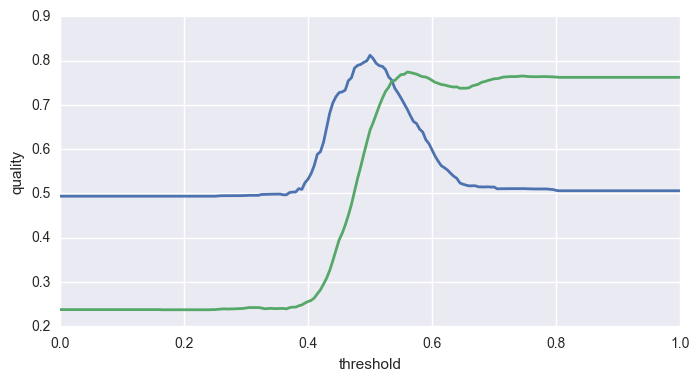

In [320]:
lrclf_params = {"C": 0.0008, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l2"}
lrfit_params = {}
lr_res = cv_fit_predict(LogisticRegression, tt, lr_f, lrclf_params, lrfit_params, do_scaling = True)
lr_p, lr_pr = combine_results(lr_res, cv, f_df.shape[0])
review(f_df, lr_p, lr_pr, "ibs", plot=True, text=True)

In [321]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

Отобранные признаки для xgboost

In [304]:
xgb_f = [u'REC', u'DET', u'Ev', "cor_d", u'ap_e', u'se', u'dfa', u'sh_en', "SD1", "SD2"]

In [317]:
xgbclf_params = {"objective":"binary:logistic", "max_depth":4, "learning_rate":0.05,
                 "n_estimators": 515, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"error", "early_stopping_rounds":90000, "verbose":False}
xgb_res = cv_fit_predict(xgb.XGBClassifier, tt, xgb_f, xgbclf_params, xgbfit_params, do_scaling = False, xgbfit = True)
xgb_a, xgb_pr = combine_results(xgb_res, cv,  df.shape[0])

100%|██████████| 20/20 [00:14<00:00,  1.32it/s]


roc-auc = 0.73847254053
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.725496688742
Качество по людям = 0.806021932342
Наилучшее разбиение происходит при границе 0.445
Качество по сигналам = 0.710927152318
Качество по людям = 0.811849745667


0.81184974566677226

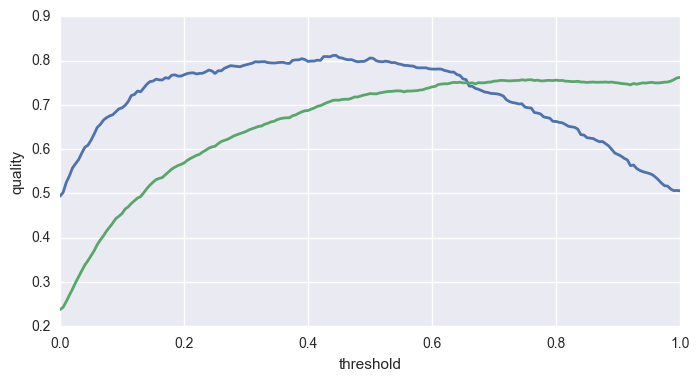

In [318]:
review(df, xgb_a, xgb_pr, "ibs")

Линейная комбинация и ее результат 

In [324]:
def patient_score(df, pr):
    df = df.copy()
    lsp = np.linspace(0, 1, 201)
    p = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df["ibs"] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() 
         for l in lsp]
    tmax = np.argmax(p)
    return p[tmax]

In [322]:
def linear_combination(df, res1, res2, cv):
    l_cv = list(cv)
    cv_answer = []
    print len(res1)
    for j in tqdm(range(len(res1))):
        print j
        scores = []
        for i in tqdm(np.arange(0, 1.005, 0.01)):
            y_pr = [a["pr_test"] * 1.0 * i  + (1-i) * 1.0 * b["pr_test"] for a, b in zip(res1[:j] + res1[j+1:],
                                                   res2[:j] + res2[j+1:])]
            s = [i, 1-i, [patient_score(df.loc[tst[1],:], pr) 
                          for pr, tst in  zip(y_pr, l_cv[:j] + l_cv[j+1:])]]
            scores.append(s)
        b = sorted(scores, key = lambda x: np.array(x[2]).mean())
        print np.mean(b[len(b)-1][2])
        alpha = b[len(b)-1][0]
        print alpha
        pr_tst = alpha * res1[j]["pr_test"] + (1.0-alpha) * res2[j]["pr_test"]
        answer = {"p_test" : None, "pr_test" : pr_tst}
        cv_answer.append(answer)
    return cv_answer

In [325]:
cv_l = linear_combination(df, xgb_res, lr_res, cv)

  0%|          | 0/101 [00:00<?, ?it/s]

20
0



  0%|          | 0/101 [00:00<?, ?it/s]

0.925483076995
0.17
1



  0%|          | 0/101 [00:00<?, ?it/s]

0.925483076995
0.17
2



  0%|          | 0/101 [00:00<?, ?it/s]

0.925483076995
0.17
3



  0%|          | 0/101 [00:00<?, ?it/s]

0.925483076995
0.17
4



  0%|          | 0/101 [00:00<?, ?it/s]

0.925483076995
0.17
5



  0%|          | 0/101 [00:00<?, ?it/s]

0.925483076995
0.17
6



  0%|          | 0/101 [00:00<?, ?it/s]

0.928003370265
0.17
7



  0%|          | 0/101 [00:00<?, ?it/s]

0.927803533308
0.17
8



  0%|          | 0/101 [00:00<?, ?it/s]

0.930117304072
0.17
9



  0%|          | 0/101 [00:00<?, ?it/s]

0.931496938896
0.15
10



  0%|          | 0/101 [00:00<?, ?it/s]

0.931753382388
0.17
11



  0%|          | 0/101 [00:00<?, ?it/s]

0.929718975383
0.17
12



  0%|          | 0/101 [00:00<?, ?it/s]

0.929482659284
0.17
13



  0%|          | 0/101 [00:00<?, ?it/s]

0.935571096086
0.17
14



  0%|          | 0/101 [00:00<?, ?it/s]

0.927339228812
0.17
15



  0%|          | 0/101 [00:00<?, ?it/s]

0.929614301521
0.17
16



  0%|          | 0/101 [00:00<?, ?it/s]

0.934228425214
0.17
17



  0%|          | 0/101 [00:00<?, ?it/s]

0.933396800698
0.17
18



  0%|          | 0/101 [00:00<?, ?it/s]

0.930234538983
0.17
19



100%|██████████| 20/20 [2:52:04<00:00, 541.42s/it]

0.932713664494
0.15


roc-auc = 0.715562221539
Наилучшее разбиение происходит при границе 0.46
Качество по сигналам = 0.647682119205
Качество по людям = 0.83958728186


0.83958728185975795

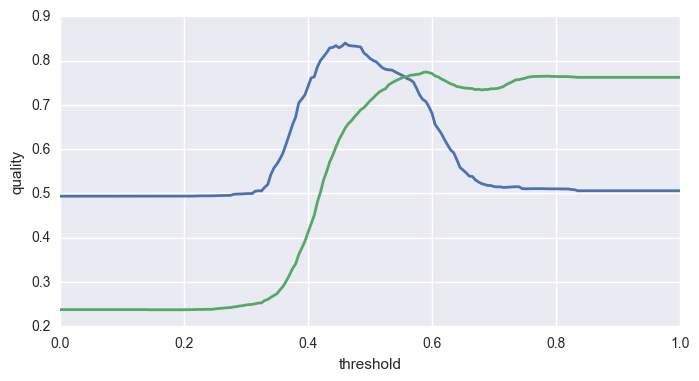

In [326]:
a, pr = combine_results(cv_l, cv, df.shape[0]) 
review(df, p=None, pr=pr)